In [ ]:
def h_measure_fin(LH, pi0, pi1, B0, B1):
    return 1 - (LH/(pi0*B0 + pi1*B1))

In [4]:
from scipy.stats import beta as beta_dist
from scipy.special import beta as beta_func
from scipy.special import betainc as betainc_func
from scipy.spatial import ConvexHull as chull
from scipy.spatial import ConvexHull
import numpy

In [41]:
def generate_B_coefs(a, b, n0, n1):
    pi1 = n1 / (n1 + n0)
    b10 = beta_func((1+a), b)
    b01 = beta_func(a, (1+b))
    b00 = beta_func(a, b)
    B0 = beta_dist.cdf(x=pi1, a=(1+a), b=b) * b10/b00
    B1 = ( beta_dist.cdf(x=1, a=a, b=(1+b)) - beta_dist.cdf(x=pi1, a=a, b=(1+b)) ) * b01/b00
    return B0, B1

In [ ]:
def generate_LH(n0, n1, G0, G1, b0, b1, debug:bool = False):
    pi1 = n1 / (n1 + n0)
    pi0 = n0 / (n1 + n0)
    b0_head = b0[1:]
    b0_norm = b0[:-1]
    b1_head = b0[1:]
    b1_norm = b0[:-1]
    
    LH_array = ( pi0 * (1 - G0) * (b0_head - b0_norm) ) + ( pi1 * G1 * (b1_head - b1_norm))
    if debug:
        return LH_array
    return sum(LH_array)

In [ ]:
def generate_cost(n0, n1, G0, G1):
    pi1 = n1 / (n1 + n0)
    pi0 = n0 / (n1 + n0)
    cost = [0]
    G1_head = G1[1:]
    G1_norm = G1[:-1]
    
    c1 = pi1 * (G1_head - G1_norm)
    c0 = pi0 * (G0_head - G0_norm)
    
    cost = cost.extend( c1 / (c1 + c0) )
    return cost

In [ ]:
def generate_b_vecs(cost, a, b):
    b10 = beta_func((1+a), b)
    b01 = beta_func(a, (1+b))
    b00 = beta_func(a, b)
    b0 = beta_dist.cdf(x=cost, a = (1 + a), b = b) * b10 / b00
    b1 = beta_dist.cdf(x=cost, a = a, b = (1 + b)) * b01 / b00

In [ ]:
def generate_beta_params(n0, n1, sev_ratio):
    if sev_ratio is None:
        sev_ratio = n1 / n0
    if sev_ratio > 0:
        a = 2
        b = 1 + (a - 1) * 1/sev_ratio
    elif sev_ratio < 0:
        a = n0/(n0+n1)
        b = n1/(n0+n1)
    else:
        raise ValueError
    return a, b

In [ ]:
from sklearn.metrics import roc_curve


In [ ]:
def generate_chull_points(y, scores):
    fpr, tpr, thresholds = roc_curve(y, scores)
    fnr = 1 - tpr
    
    pairwise_max = numpy.maximum(fnr, fpr)
    chull_candidates = numpy.array([fpr, pairwise_max]).transpose()
    
    assert chull_candidates.shape == (len(fnr), 2)
    hull = ConvexHull(chull_candidates)
    G0 = chull_candidates[hull.vertices, 0]
    G1 = chull_candidates[hull.vertices, 1]
    return G0, G1

In [2]:
chull_test = [-0.626453810742332,0.183643324222082,-0.835628612410047,1.59528080213779,0.329507771815361,-0.820468384118015,0.487429052428485,0.738324705129217,0.575781351653492,-0.305388387156356]

In [5]:
1-numpy.array(chull_test)

array([ 1.62645381,  0.81635668,  1.83562861, -0.5952808 ,  0.67049223,
        1.82046838,  0.51257095,  0.26167529,  0.42421865,  1.30538839])

In [6]:
chull_test_2d = numpy.array([chull_test, list(range(1,11))]).transpose()

In [7]:
assert chull_test_2d.shape == (len(chull_test), 2)

In [8]:
hull  = chull(chull_test_2d)

In [9]:
hull.vertices

array([2, 0, 1, 3, 8, 9, 5], dtype=int32)

In [10]:
chull_test_2d

array([[-0.62645381,  1.        ],
       [ 0.18364332,  2.        ],
       [-0.83562861,  3.        ],
       [ 1.5952808 ,  4.        ],
       [ 0.32950777,  5.        ],
       [-0.82046838,  6.        ],
       [ 0.48742905,  7.        ],
       [ 0.73832471,  8.        ],
       [ 0.57578135,  9.        ],
       [-0.30538839, 10.        ]])

In [11]:
hull.simplices

array([[0, 2],
       [5, 2],
       [5, 9],
       [8, 3],
       [8, 9],
       [1, 3],
       [1, 0]], dtype=int32)

In [119]:
for simplex in hull.simplices:
    print(simplex)
    print(chull_test_2d[simplex, 0])
    print(chull_test_2d[simplex, 1])

[0 2]
[-0.62645381 -0.83562861]
[1. 3.]
[5 2]
[-0.82046838 -0.83562861]
[6. 3.]
[5 9]
[-0.82046838 -0.30538839]
[ 6. 10.]
[8 3]
[0.57578135 1.5952808 ]
[9. 4.]
[8 9]
[ 0.57578135 -0.30538839]
[ 9. 10.]
[1 3]
[0.18364332 1.5952808 ]
[2. 4.]
[1 0]
[ 0.18364332 -0.62645381]
[2. 1.]


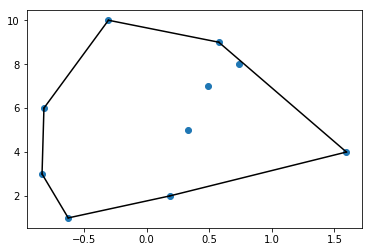

In [13]:
import matplotlib.pyplot as plt
plt.plot(chull_test_2d[:,0], chull_test_2d[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(chull_test_2d[simplex, 0], chull_test_2d[simplex, 1], 'k-')

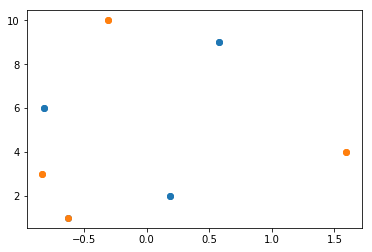

In [15]:
plt.plot(chull_test_2d[hull.simplices, 0], chull_test_2d[hull.simplices, 1], 'o')

In [136]:
hull.vertices

array([2, 0, 1, 3, 8, 9, 5], dtype=int32)

In [137]:
chull_test_2d[hull.vertices,1]

array([ 3.,  1.,  2.,  4.,  9., 10.,  6.])

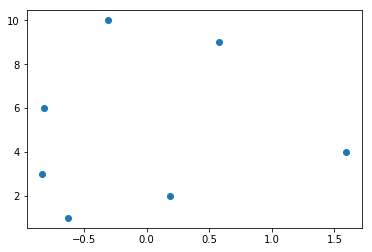

In [138]:
plt.plot(chull_test_2d[hull.vertices,0], chull_test_2d[hull.vertices,1], 'o', lw=2)

In [51]:
import numpy

In [65]:
def convex_hull(points):
    """Computes the convex hull of a set of 2D points.

    Input: an iterable sequence of (x, y) pairs representing the points.
    Output: a list of vertices of the convex hull in counter-clockwise order,
      starting from the vertex with the lexicographically smallest coordinates.
    Implements Andrew's monotone chain algorithm. O(n log n) complexity.
    """

    # Sort the points lexicographically (tuples are compared lexicographically).
    # Remove duplicates to detect the case we have just one unique point.
    points = sorted(set(points))

    # Boring case: no points or a single point, possibly repeated multiple times.
    if len(points) <= 1:
        return points

    # 2D cross product of OA and OB vectors, i.e. z-component of their 3D cross product.
    # Returns a positive value, if OAB makes a counter-clockwise turn,
    # negative for clockwise turn, and zero if the points are collinear.
    def cross(o, a, b):
        return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

    # Build lower hull 
    lower = []
    for p in points:
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(p)

    # Build upper hull
    upper = []
    for p in reversed(points):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)

    # Concatenation of the lower and upper hulls gives the convex hull.
    # Last point of each list is omitted because it is repeated at the beginning of the other list. 
    return lower[:-1] + upper[:-1]

In [ ]:
test_list = numpy.array([chull_test, list(range(1,11))]).transpose().tolist()

In [117]:
convex_hull([tuple(x) for x in test_list])

[(-0.835628612410047, 3.0),
 (-0.626453810742332, 1.0),
 (0.183643324222082, 2.0),
 (1.59528080213779, 4.0),
 (0.575781351653492, 9.0),
 (-0.305388387156356, 10.0),
 (-0.820468384118015, 6.0)]

In [140]:
type(numpy.maximum([2, 3, 4], [1, 5, 2]))

numpy.ndarray